In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.7 MB/s eta 0:00:00


In [ ]:
#download data from kaggle and put in directory called deepglobe_dataset
!mkdir -p deepglobe_dataset
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset -p deepglobe_dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.74G/2.74G [00:30<00:00, 110MB/s]
100% 2.74G/2.74G [00:30<00:00, 95.3MB/s]


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd

train_dir = os.path.join("./deepglobe_dataset/", "train") #train directory
class_dict_path = os.path.join("./deepglobe_dataset/", "class_dict.csv")

# Load color mappings from CSV
color_map = {}
df = pd.read_csv(class_dict_path)
for idx, row in df.iterrows():
    color = (row['r'], row['g'], row['b'])
    color_map[color] = idx

def load_and_process_image(image_path):
    """Load and preprocess the satellite image."""
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Resize if necessary
    return np.array(image) / 255.0    # Normalize to 0-1

def load_and_process_mask(mask_path):
    """Load and preprocess the mask image, converting colors to class indices."""
    mask = Image.open(mask_path).convert('RGB')
    mask = mask.resize((256, 256))
    mask_array = np.array(mask)
    class_mask = np.zeros(mask_array.shape[:2], dtype=np.int32)
    for color, class_idx in color_map.items():
        matches = (mask_array == color).all(axis=-1)
        class_mask[matches] = class_idx
    return class_mask

# Load and organize images and masks
X, y = [], []
for filename in os.listdir(train_dir):
    if filename.endswith('_sat.jpg'):
        img_id = filename.split('_')[0]
        sat_img_path = os.path.join(train_dir, f"{img_id}_sat.jpg")
        mask_img_path = os.path.join(train_dir, f"{img_id}_mask.png")

        if os.path.exists(sat_img_path) and os.path.exists(mask_img_path):
            # Load and process both images
            X.append(load_and_process_image(sat_img_path))
            y.append(load_and_process_mask(mask_img_path))

# Convert lists to arrays
X = np.array(X)
y = np.array(y)



In [ ]:
y[0][0]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 1, 0, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
X.shape

(803, 256, 256, 3)

In [ ]:
color_map

{(0, 255, 255): 0,
 (255, 255, 0): 1,
 (255, 0, 255): 2,
 (0, 255, 0): 3,
 (0, 0, 255): 4,
 (255, 255, 255): 5,
 (0, 0, 0): 6}

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image

In [ ]:
DATA_DIR = './deepglobe_dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

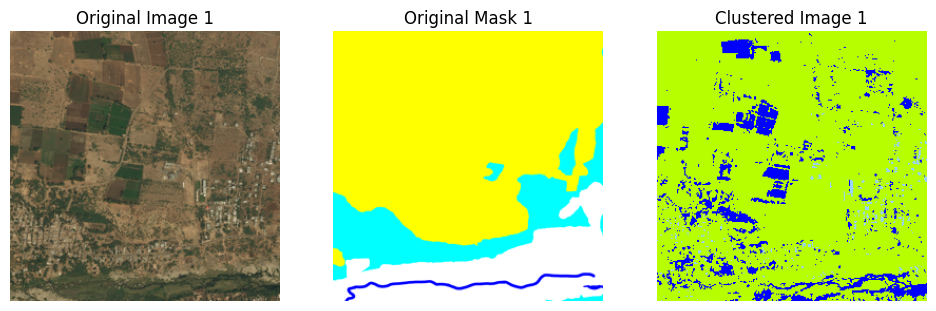

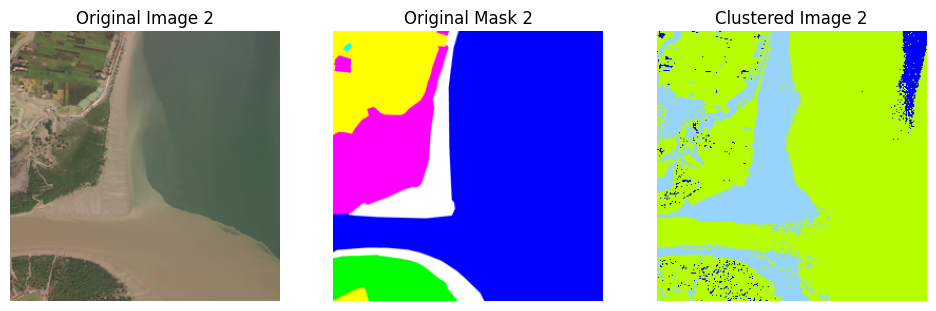

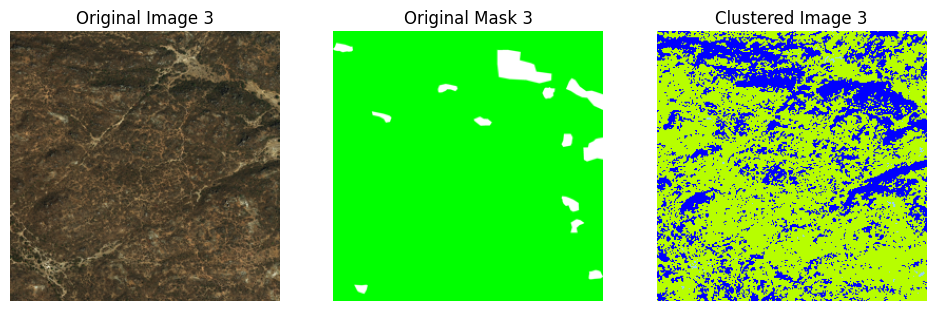

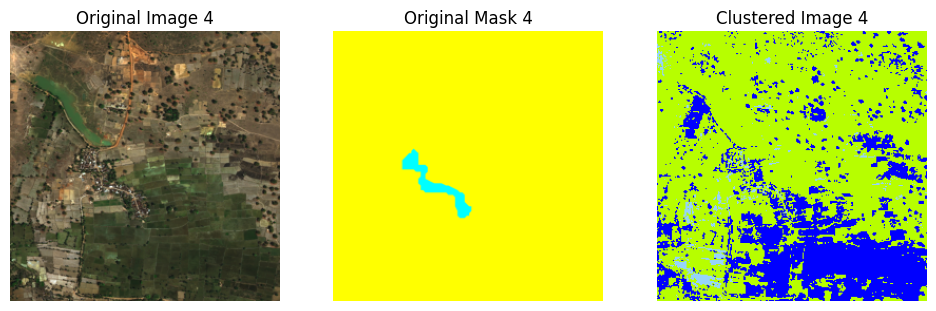

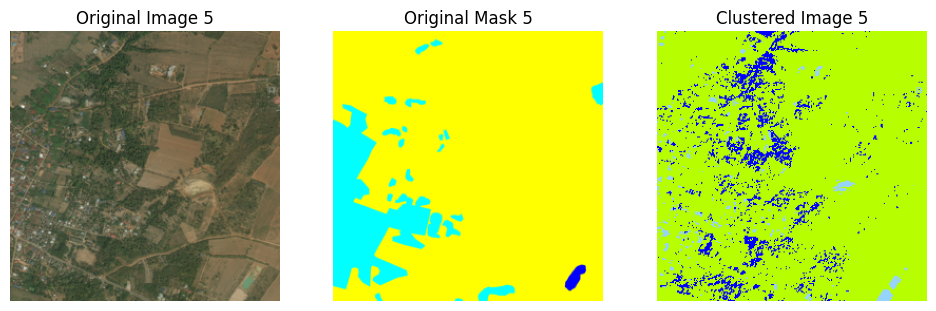

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image

# Process the first five masks and corresponding images for clustering
X_mask_data = []
mask_shapes = []  # To store original shapes for reshaping later
original_masks = []  # To keep track of original mask images for later comparison
original_images = []  # To keep track of original satellite images for display

for idx, row in metadata_df.head(5).iterrows():
    # Load and process the mask
    mask = Image.open(row['mask_path']).convert('RGB')
    mask = mask.resize((256, 256))  # Ensure consistent shape if needed
    mask_array = np.array(mask)
    original_masks.append(mask_array)  # Save the original mask for comparison

    # Load and process the corresponding original image
    image = Image.open(row['sat_image_path']).convert('RGB')
    image = image.resize((256, 256))  # Ensure consistent shape if needed
    image_array = np.array(image)
    original_images.append(image_array)  # Save original image for visualization

    # Store shape for reshaping later
    mask_shapes.append(mask_array.shape)

    # Flatten and add to data
    X_mask_data.append(mask_array.reshape(-1, 3))  # Flatten mask

# Combine all mask data for clustering
X_mask_data = np.vstack(X_mask_data)

# Perform K-means clustering
num_clusters = 3  # Set the number of clusters; adjust as necessary
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_mask_data)

# Retrieve cluster labels and centers
mask_cluster_labels = kmeans.labels_
mask_cluster_centers = kmeans.cluster_centers_

# Visualize original images, original and clustered mask images
start_idx = 0
for i, shape in enumerate(mask_shapes):
    # Extract clustering labels for this mask
    num_pixels = shape[0] * shape[1]
    labels = mask_cluster_labels[start_idx:start_idx + num_pixels]
    start_idx += num_pixels

    # Reshape labels to match the original mask's dimensions
    clustered_mask = labels.reshape(shape[0], shape[1])

    # Replace each cluster label with its corresponding color (closest original RGB value)
    clustered_colors = mask_cluster_centers[clustered_mask].astype(np.uint8)

    # Display the original image, original mask, clustered image, and clustered mask
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 4, 1)
    plt.title(f"Original Image {i+1}")
    plt.imshow(original_images[i])
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title(f"Original Mask {i+1}")
    plt.imshow(original_masks[i])
    plt.axis('off')

    # Optionally, cluster the original image for comparison (not mandatory, but illustrative)
    clustered_image = kmeans.predict(original_images[i].reshape(-1, 3))
    clustered_image_colors = mask_cluster_centers[clustered_image].reshape(shape).astype(np.uint8)

    plt.subplot(1, 4, 3)
    plt.title(f"Clustered Image {i+1}")
    plt.imshow(clustered_image_colors)
    plt.axis('off')

    plt.show()






/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (133829318 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Image shape: (12719, 10522, 3)


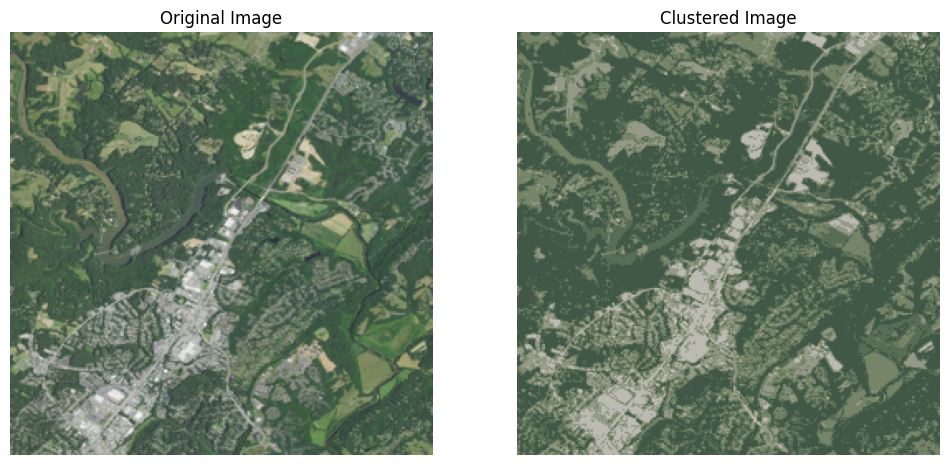

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

image = Image.open('charlottesville.tif')
image = image.convert('RGB')
image_data = np.array(image)
print(f"Image shape: {image_data.shape}")

# If the image is very large, you can resize it for faster processing (optional)
image = image.resize((256, 256))  # Resize as needed
image_data = np.array(image)

# Flatten the image data for clustering (reshape to 2D array: num_pixels x num_channels)
height, width, num_channels = image_data.shape
image_data_flattened = image_data.reshape(-1, num_channels)

# Perform K-means clustering
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_data_flattened)

# Retrieve the cluster labels and reshape them to the original image shape
cluster_labels = kmeans.labels_.reshape(height, width)

# Map each label to its corresponding cluster center color
clustered_image = kmeans.cluster_centers_[cluster_labels].astype(np.uint8)

# Visualize the original and clustered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# Display clustered image
plt.subplot(1, 2, 2)
plt.title("Clustered Image")
plt.imshow(clustered_image)
plt.axis('off')

plt.show()



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (133829318 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
<ipython-input-3-32ca56575e4e>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', num_clusters)  # Use any preferred colormap ('viridis' in this example)


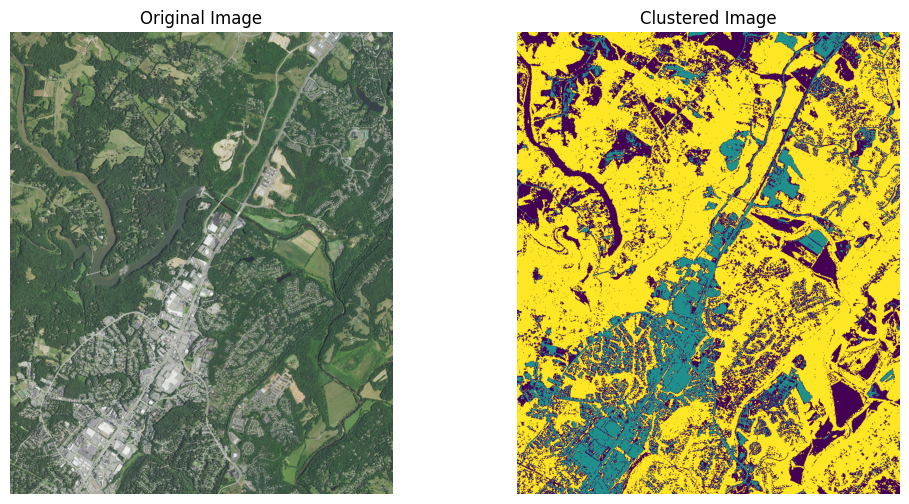

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load the Charlottesville TIFF image using Pillow
image = Image.open('charlottesville.tif')
image = image.convert('RGB')

#image.thumbnail((1000, 1000))  # Resize maintaining aspect ratio to max 1000x1000 pixels
#image.resize((256,256))
image.thumbnail((1024, 1024))
# Convert image data to a NumPy array
image_data = np.array(image)

# Flatten the image data for clustering (reshape to 2D array: num_pixels x num_channels)
height, width, num_channels = image_data.shape
image_data_flattened = image_data.reshape(-1, num_channels)

# Perform K-means clustering
num_clusters =3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_data_flattened)

# Retrieve the cluster labels and reshape them to the original image shape
cluster_labels = kmeans.labels_.reshape(height, width)

# Apply a colormap to the cluster labels
colormap = cm.get_cmap('viridis', num_clusters)  # Use any preferred colormap ('viridis' in this example)
colored_clustered_image = colormap(cluster_labels / (num_clusters - 1))  # Normalize labels for colormap
colored_clustered_image = (colored_clustered_image[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB values

# Visualize the original and clustered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# Display clustered image with colormap
plt.subplot(1, 2, 2)
plt.title("Clustered Image")
plt.imshow(colored_clustered_image)
plt.axis('off')

plt.show()


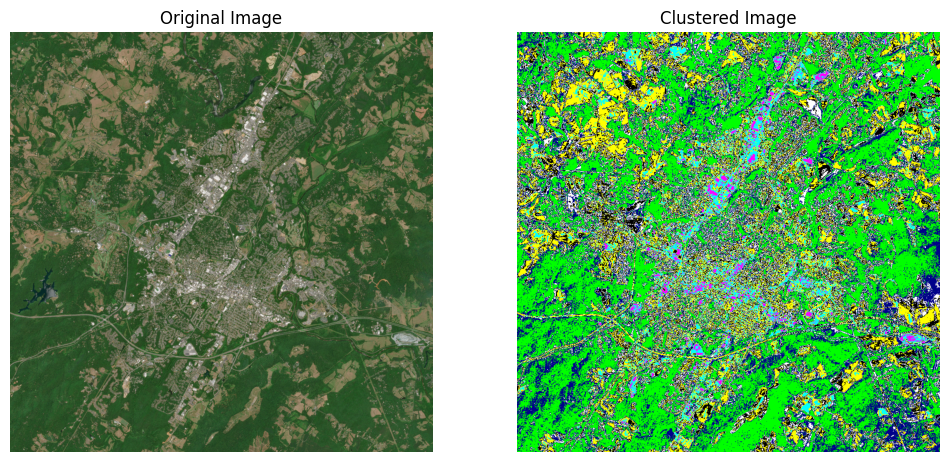

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

image = Image.open('charlottesville.jpg')
image = image.convert('RGB')
image.thumbnail((1024, 1024))

# Convert image data to a NumPy array
image_data = np.array(image)

# Flatten the image data for clustering (reshape to 2D array: num_pixels x num_channels)
height, width, num_channels = image_data.shape
image_data_flattened = image_data.reshape(-1, num_channels)

# Perform K-means clustering
num_clusters = 7  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_data_flattened)

# Retrieve the cluster labels and reshape them to the original image shape
cluster_labels = kmeans.labels_.reshape(height, width)

# Define the custom colormap
custom_colors = [
    (0.0, 1.0, 1.0),  # Cyan
    (0.0, 0.0, 0.545),  # Dark Blue
    (1.0, 1.0, 0.0),  # Yellow
    (1.0, 0.0, 1.0),  # Fuchsia (Magenta)
    (0.0, 1.0, 0.0),  # Green
    (1.0, 1.0, 1.0),  # White
    (0.0, 0.0, 0.0),  # Black
]

# Create a ListedColormap using the custom colors
custom_cmap = mcolors.ListedColormap(custom_colors)

# Apply the custom colormap to the cluster labels
colored_clustered_image = custom_cmap(cluster_labels / (num_clusters - 1))  # Normalize labels for colormap
colored_clustered_image = (colored_clustered_image[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB values

# Visualize the original and clustered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# Display clustered image with custom colormap
plt.subplot(1, 2, 2)
plt.title("Clustered Image")
plt.imshow(colored_clustered_image)
plt.axis('off')

plt.show()


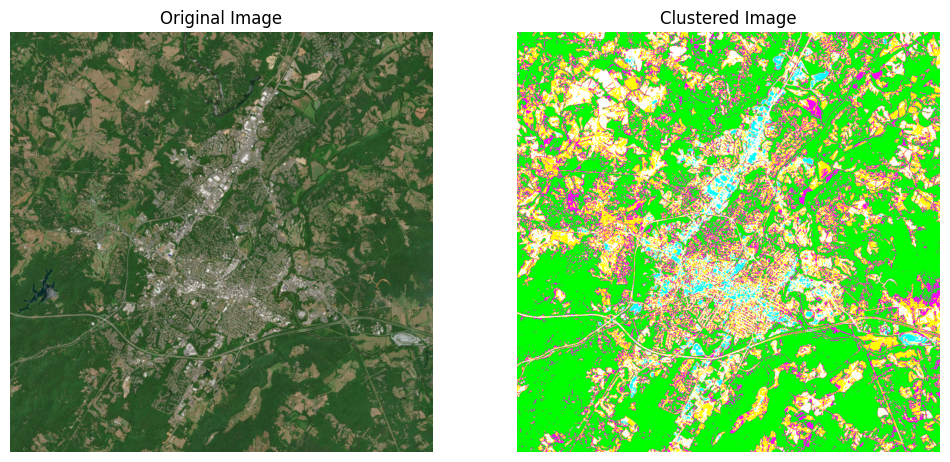

In [ ]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

image = Image.open('charlottesville.jpg')
image = image.convert('RGB')

# Resize the image to reduce memory usage
image.thumbnail((1024, 1024))

image_data = np.array(image)

# Flatten the image data for clustering (reshape to 2D array: num_pixels x num_channels)
height, width, num_channels = image_data.shape
image_data_flattened = image_data.reshape(-1, num_channels)

# Perform K-means clustering
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_data_flattened)

# Retrieve the cluster labels and reshape them to the original image shape
cluster_labels = kmeans.labels_.reshape(height, width)

# Define the custom colormap
custom_colors = [
    (1.0, 1.0, 1.0),  # White
    (1.0, 0.0, 1.0),  # Fuchsia (Magenta)
    (1.0, 1.0, 0.0),  # Yellow
    (0.0, 1.0, 1.0),  # Cyan
    (0.0, 1.0, 0.0),  # Green
]

# Create a ListedColormap using the custom colors
custom_cmap = mcolors.ListedColormap(custom_colors)

# Apply the custom colormap to the cluster labels
colored_clustered_image = custom_cmap(cluster_labels / (num_clusters - 1))  # Normalize labels for colormap
colored_clustered_image = (colored_clustered_image[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB values

# Visualize the original and clustered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# Display clustered image with custom colormap
plt.subplot(1, 2, 2)
plt.title("Clustered Image")
plt.imshow(colored_clustered_image)
plt.axis('off')

plt.show()

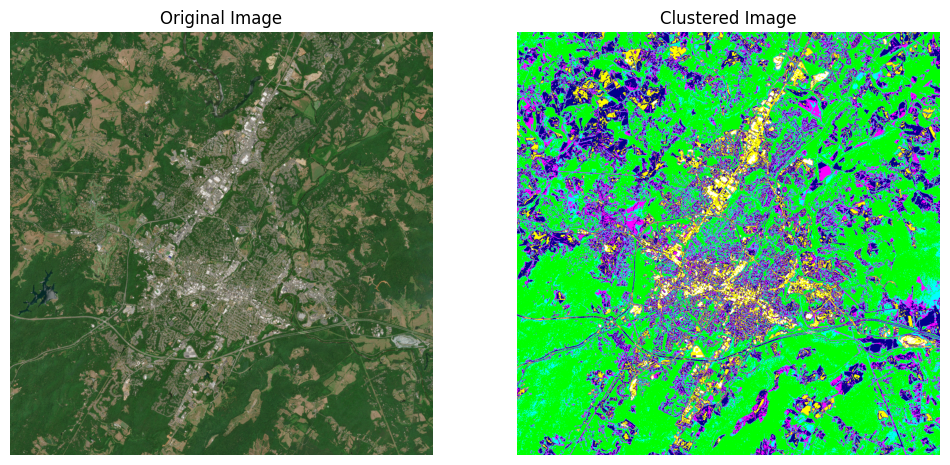

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_image(image_path):
    """Load and preprocess an image for clustering."""
    # Load the image in RGB format
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    resized_image = cv2.resize(image, (2048, 2048), interpolation=cv2.INTER_LINEAR)

    return resized_image, image.shape[:2]  # Return resized image and original shape

# Load and preprocess the image
image_path = 'charlottesville.jpg'
resized_image, original_shape = load_image(image_path)

# Convert image data to a NumPy array
image_data = np.array(resized_image)

# Flatten the image data for clustering (reshape to 2D array: num_pixels x num_channels)
height, width, num_channels = image_data.shape
image_data_flattened = image_data.reshape(-1, num_channels)

# Perform K-means clustering
num_clusters = 6  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_data_flattened)

# Retrieve the cluster labels and reshape them to the original image shape
cluster_labels = kmeans.labels_.reshape(height, width)

# Define the custom colormap
custom_colors = [
    (0.0, 1.0, 1.0),  # Cyan
    (0.0, 0.0, 0.545),  # Dark Blue
    (1.0, 1.0, 0.0),  # Yellow
    (1.0, 0.0, 1.0),  # Fuchsia (Magenta)
    (0.0, 1.0, 0.0),  # Green
    (1.0, 1.0, 1.0),  # White
]

# Create a ListedColormap using the custom colors
custom_cmap = mcolors.ListedColormap(custom_colors)

# Apply the custom colormap to the cluster labels
colored_clustered_image = custom_cmap(cluster_labels / (num_clusters - 1))  # Normalize labels for colormap
colored_clustered_image = (colored_clustered_image[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB values

# Visualize the original and clustered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(resized_image)
plt.axis('off')

# Display clustered image with custom colormap
plt.subplot(1, 2, 2)
plt.title("Clustered Image")
plt.imshow(colored_clustered_image)
plt.axis('off')

plt.show()


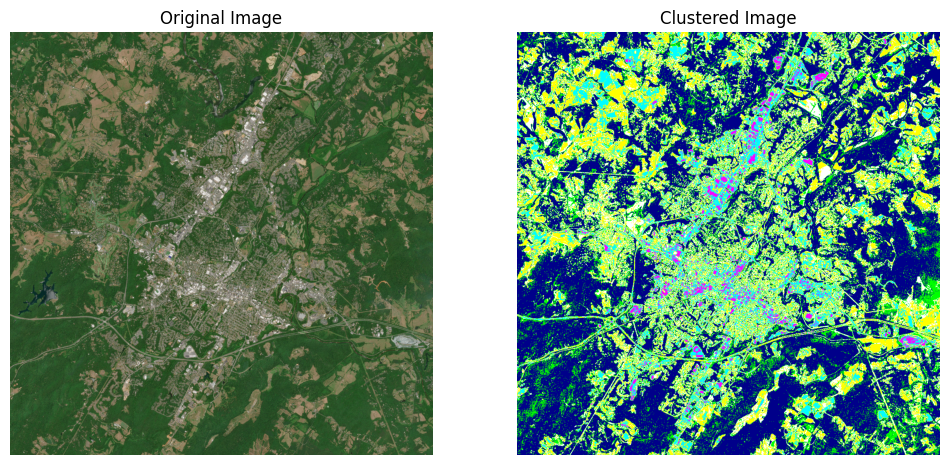

In [5]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_image(image_path):
    """Load and preprocess an image for clustering."""
    # Load the image in RGB format
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    resized_image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)

    return resized_image, image.shape[:2]  # Return resized image and original shape

# Load and preprocess the image
image_path = 'charlottesville.jpg'
resized_image, original_shape = load_image(image_path)

# Convert image data to a NumPy array
image_data = np.array(resized_image)

# Flatten the image data for clustering (reshape to 2D array: num_pixels x num_channels)
height, width, num_channels = image_data.shape
image_data_flattened = image_data.reshape(-1, num_channels)

# Perform K-means clustering
num_clusters = 6  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_data_flattened)

# Retrieve the cluster labels and reshape them to the original image shape
cluster_labels = kmeans.labels_.reshape(height, width)

# Define the custom colormap
custom_colors = [
    (0.0, 1.0, 1.0),  # Cyan
    (0.0, 0.0, 0.545),  # Dark Blue
    (1.0, 1.0, 0.0),  # Yellow
    (1.0, 0.0, 1.0),  # Fuchsia (Magenta)
    (0.0, 1.0, 0.0),  # Green
    (1.0, 1.0, 1.0),  # White
]

# Create a ListedColormap using the custom colors
custom_cmap = mcolors.ListedColormap(custom_colors)

# Apply the custom colormap to the cluster labels
colored_clustered_image = custom_cmap(cluster_labels / (num_clusters - 1))  # Normalize labels for colormap
colored_clustered_image = (colored_clustered_image[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB values

# Visualize the original and clustered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(resized_image)
plt.axis('off')

# Display clustered image with custom colormap
plt.subplot(1, 2, 2)
plt.title("Clustered Image")
plt.imshow(colored_clustered_image)
plt.axis('off')

plt.show()